# Milestone 2

### Avant de commencer. Merci de lire bien attentivement le README.md pour cette seconde partie.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# all imports
from src import *
import pandas as pd
import os.path
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import wandb
import pickle
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import config
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# commenté car j'ai des érreurs liées au package torch qui est assez complique a installer windows
#from src.models import model_start

## Data acquisition

In [3]:
filename = './data/dataframe_2016_to_2019.csv'
start_year = 2016
end_year = 2019

if not os.path.isfile(filename):
    # Get the data from the NHL API (2016 - 2019)
    nhl_data_provider = get_data_from(start_year, end_year)

    # Clean the data
    clean_regular_season, clean_playoff = clean_data(nhl_data_provider)

    # Transform data into dataframe
    df_2016_to_2019 = convert_dictionaries_to_dataframes(clean_regular_season,
                                                         clean_playoff,
                                                         np.arange(start_year, end_year + 1).tolist())
    df_2016_to_2019.to_csv(filename, index=False)

Successfully imported NHL data for the 2016 season.
Data was successfully imported: data/regular_season/2017\2017_0890.json
Data was successfully imported: data/regular_season/2017\2017_0891.json
Data was successfully imported: data/regular_season/2017\2017_0892.json
Data was successfully imported: data/regular_season/2017\2017_0893.json
Data was successfully imported: data/regular_season/2017\2017_0894.json
Data was successfully imported: data/regular_season/2017\2017_0895.json
Data was successfully imported: data/regular_season/2017\2017_0896.json
Data was successfully imported: data/regular_season/2017\2017_0897.json
Data was successfully imported: data/regular_season/2017\2017_0898.json
Data was successfully imported: data/regular_season/2017\2017_0899.json
Data was successfully imported: data/regular_season/2017\2017_0900.json
Data was successfully imported: data/regular_season/2017\2017_0901.json
Data was successfully imported: data/regular_season/2017\2017_0902.json
Data was suc

#### Récupération des données d'entraînement

In [4]:
train_data = pd.read_csv(filename)

# Ingénierie des caractéristiques I

## Question 1

In [5]:
count_table = pd.crosstab(train_data['isGoal'], train_data['typeDescKey'])
# count_table2 = pd.crosstab(train_data['emptyGoalNet_0_1'],train_data['emptyGoalNet'])

count_table
# count_table2

typeDescKey,goal,shot-on-goal
isGoal,,
0,0,296406
1,30936,0


#### Histogramme du nombre de tirs (buts et non-buts séparés), regroupés par distance

##### Variables distance de tir et angle de tir regroupées

In [6]:
# Binning de la distance en intervalles de 20 pieds
train_data.loc[:,'shotDistance_bin'] = pd.cut(train_data['shotDistance'], bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200], labels=['0-19', '20-39', '40-59', '60-79', '80-99', '100-119', '120-139', '140-159', '160-179', '180-200'])

train_data.loc[:,'shotAngle_bin'] = pd.cut(train_data['shotAngle'], bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180], labels=['0-19', '20-39', '40-59', '60-79', '80-99', '100-119', '120-139', '140-159', '160-179'])


train_data


,Year,idGame,gameType,periodType,numberPeriod,typeDescKey,eventOwnerTeam,gameSeconds,previousEventType,timeSinceLastEvent,...,isGoal,shotDistance,distanceFromLastEvent,rebound,speedFromLastEvent,shotAngle,reboundAngleShot,offensivePressureTime,shotDistance_bin,shotAngle_bin
0,2016,2016020001,regular-season,REG,1,shot-on-goal,Maple Leafs,71,blocked-shot,1.0,...,0,13.0,17.1,False,17.100000,22.619865,0.0,0.0,0-19,20-39
1,2016,2016020001,regular-season,REG,1,shot-on-goal,Senators,173,giveaway,5.0,...,0,13.3,36.7,False,7.340000,77.005383,0.0,0.0,0-19,60-79
2,2016,2016020001,regular-season,REG,1,shot-on-goal,Senators,241,missed-shot,18.0,...,0,76.2,102.3,False,5.683333,29.931512,0.0,68.0,60-79,20-39
3,2016,2016020001,regular-season,REG,1,shot-on-goal,Senators,286,missed-shot,19.0,...,0,58.0,45.9,False,2.415789,14.995079,0.0,45.0,40-59,0-19
4,2016,2016020001,regular-season,REG,1,shot-on-goal,Maple Leafs,406,hit,16.0,...,0,61.7,81.2,False,5.075000,26.980231,0.0,335.0,60-79,20-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327337,2019,2019030416,playoffs,REG,3,shot-on-goal,Lightning,3361,giveaway,3.0,...,0,38.4,123.0,False,41.000000,38.659808,0.0,450.0,20-39,20-39
327338,2019,2019030416,playoffs,REG,3,shot-on-goal,Lightning,3440,blocked-shot,2.0,...,0,8.5,3.2,False,1.600000,20.556045,0.0,79.0,0-19,20-39
327339,2019,2019030416,playoffs,REG,3,shot-on-goal,Stars,3530,takeaway,8.0,...,0,55.3,58.9,False,7.362500,6.225829,0.0,203.0,40-59,0-19
327340,2019,2019030416,playoffs,REG,3,shot-on-goal,Stars,3567,faceoff,5.0,...,0,58.9,49.7,False,9.940000,9.782407,0.0,37.0,40-59,0-19


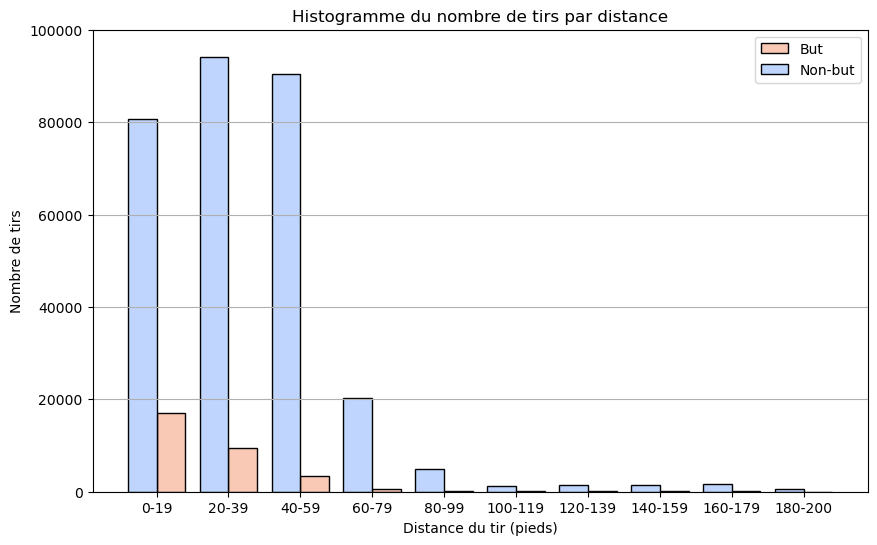

In [7]:
## Add in advancedVisualisation (by Youry)
def histogram_2_variables_binned(df, x_bin, hue, shrink, xlabel, ylabel, title, legendTitle, legendLabels):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=x_bin, hue=hue, multiple='dodge', palette='coolwarm', shrink=shrink)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0,100000)
    plt.title(title)
    plt.legend(title=legendTitle, labels=legendLabels)
    plt.grid(axis="y")
    plt.show()


histogram_2_variables_binned(df=train_data, x_bin='shotDistance_bin', hue='isGoal', shrink=0.8, xlabel='Distance du tir (pieds)', ylabel='Nombre de tirs', title='Histogramme du nombre de tirs par distance', legendTitle='', legendLabels=['But', 'Non-but'])

#### Histogramme du nombre de tirs (buts et non-buts séparés), regroupés par angle

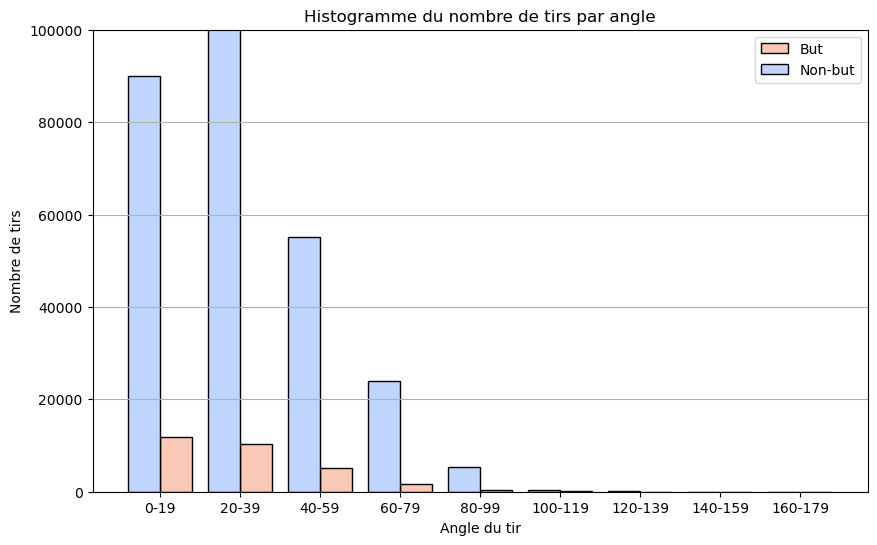

In [8]:
histogram_2_variables_binned(df=train_data, x_bin='shotAngle_bin', hue='isGoal', shrink=0.8, xlabel='Angle du tir', ylabel='Nombre de tirs', title='Histogramme du nombre de tirs par angle', legendTitle='', legendLabels=['But', 'Non-but'])

#### Histogramme 2D où un axe est la distance et l'autre est l'angle (sans distinction entre buts et non-buts)

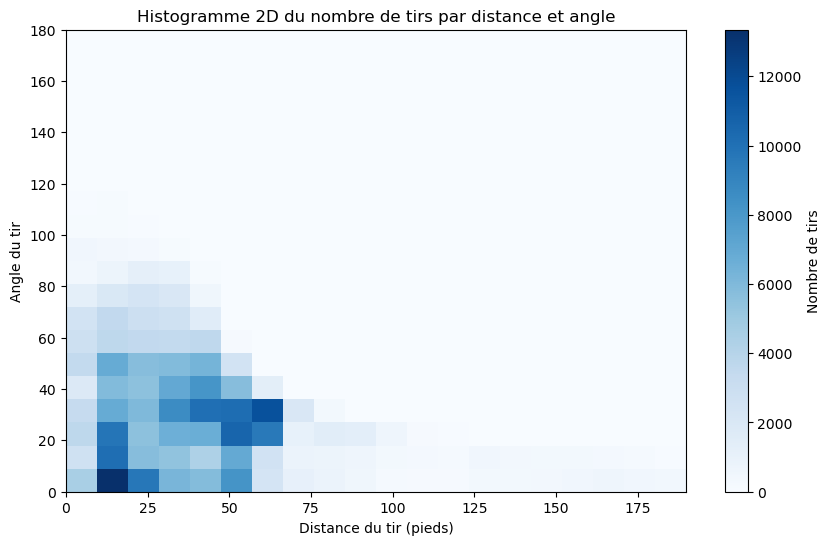

In [9]:
def histogram2D_2_variables(df, x, y, bins, label, xlabel, ylabel, title):
    # Remove rows with NaN values
    df = df.dropna(subset=[x, y])
    # Plot the histogram with hue for 'is_goal'
    plt.figure(figsize=(10, 6))
    plt.hist2d(df[x], df[y], bins=bins, cmap='Blues')
    # Customize legend labels for hue values
    plt.colorbar(label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

histogram2D_2_variables(train_data, x='shotDistance', y='shotAngle', bins=20, label='Nombre de tirs', xlabel='Distance du tir (pieds)', ylabel='Angle du tir', title='Histogramme 2D du nombre de tirs par distance et angle')

In [10]:
'''
def histogram2D_2_variables_seaborn(df, x, y, title, xlabel, ylabel, kind):
    # Remove rows with NaN values
    df = df.dropna(subset=[x, y])
    # Jointplot to visualize the 2D histogram
    sns.jointplot(data=df, x=x, y=y, kind=kind, cmap='Blues')
    # Add title and labels
    plt.suptitle(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # Show the plot
    plt.show()


# histogram2D_2_variables_seaborn(train_data, x='shotDistance', y='shotAngle', title="Histogramme 2D de la Distance et de l'Angle", xlabel='Distance du tir (pieds)', ylabel='Angle du tir',
#                         kind='kde'
#                         # kind='reg'
#                         # kind='hist'
#                         # kind='hex'
# )


g = sns.jointplot(data=train_data, x='shotAngle', y='shotDistance')
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

# Ajouter un titre, un xlabel, et un ylabel
g.ax_joint.set_title("Relation entre la distance et l'angle des tirs", fontsize=14)
g.ax_joint.set_xlabel("Angle du tir", fontsize=12)
g.ax_joint.set_ylabel("Distance du tir(pieds)", fontsize=12)

# Ajuster l'espacement du titre
plt.subplots_adjust(top=0.9)  # Ajuste la position du titre
'''

'\ndef histogram2D_2_variables_seaborn(df, x, y, title, xlabel, ylabel, kind):\n    # Remove rows with NaN values\n    df = df.dropna(subset=[x, y])\n    # Jointplot to visualize the 2D histogram\n    sns.jointplot(data=df, x=x, y=y, kind=kind, cmap=\'Blues\')\n    # Add title and labels\n    plt.suptitle(title, fontsize=16)\n    plt.xlabel(xlabel)\n    plt.ylabel(ylabel)\n    # Show the plot\n    plt.show()\n\n\n# histogram2D_2_variables_seaborn(train_data, x=\'shotDistance\', y=\'shotAngle\', title="Histogramme 2D de la Distance et de l\'Angle", xlabel=\'Distance du tir (pieds)\', ylabel=\'Angle du tir\',\n#                         kind=\'kde\'\n#                         # kind=\'reg\'\n#                         # kind=\'hist\'\n#                         # kind=\'hex\'\n# )\n\n\ng = sns.jointplot(data=train_data, x=\'shotAngle\', y=\'shotDistance\')\ng.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)\ng.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)\n\n# Ajo

## Question 2

#### Le taux de but (buts / (buts + non-buts)) par distance

In [11]:
df_distance_goal_rate = train_data.groupby('shotDistance')['isGoal'].mean().reset_index()
df_distance_goal_rate.columns = ['shotDistance', 'goalRate']

df_distance_goal_rate

,shotDistance,goalRate
0,0.0,1.000000
1,1.0,1.000000
2,1.4,0.777778
3,2.0,0.500000
4,2.2,0.550000
...,...,...
1769,188.0,0.500000
1770,188.1,0.000000
1771,188.2,0.000000
1772,188.4,0.000000


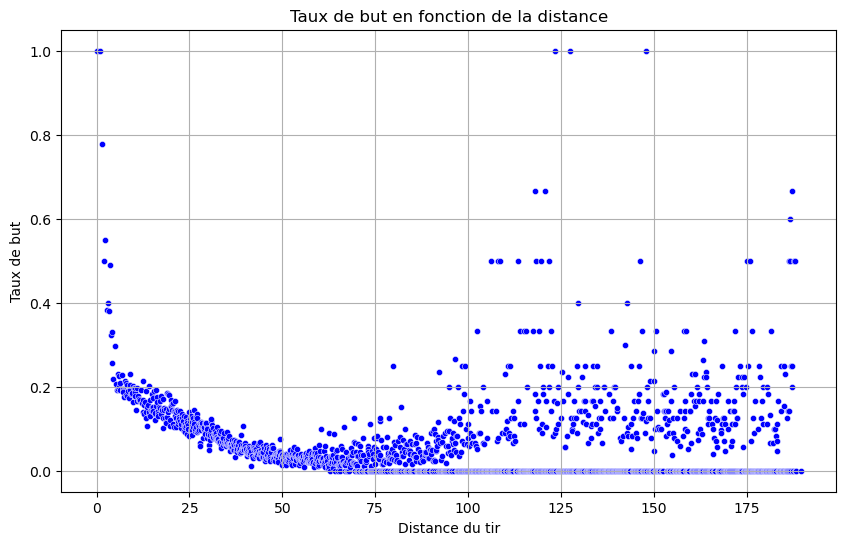

In [12]:
def scatterplot_2_variables(df, x, y, color, s, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x, y=y, color=color, s=s, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

scatterplot_2_variables(df=df_distance_goal_rate, x='shotDistance', y='goalRate',color='blue', s=20, title='Taux de but en fonction de la distance', xlabel='Distance du tir', ylabel='Taux de but')

#### Le taux de but (buts / (buts + non-buts)) par angle

In [13]:
df_angle_goal_rate = train_data.groupby('shotAngle')['isGoal'].mean().reset_index()
df_angle_goal_rate.columns = ['shotAngle', 'goalRate']

df_angle_goal_rate

,shotAngle,goalRate
0,0.000000,0.181688
1,0.306392,0.000000
2,0.309704,0.000000
3,0.329282,0.000000
4,0.331186,0.000000
...,...,...
4665,159.443955,0.000000
4666,161.565051,1.000000
4667,171.869898,1.000000
4668,173.659808,0.000000


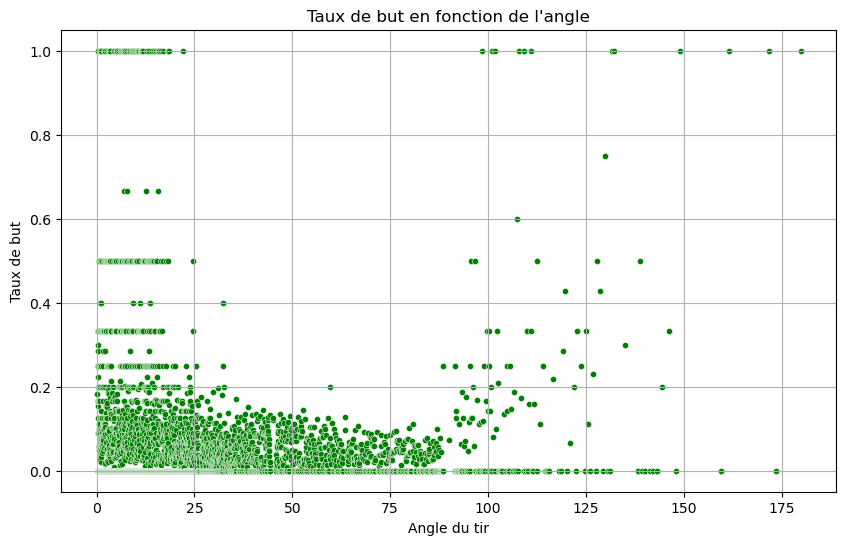

In [14]:
scatterplot_2_variables(df=df_angle_goal_rate, x='shotAngle', y='goalRate', color='green', s=20,
                        title='Taux de but en fonction de l\'angle', xlabel='Angle du tir', ylabel='Taux de but')

#### Question 2 : vaiables distance et angle binned(s)

In [15]:
# Regrouper les tirs par bins de distance
goal_stats_by_distance = train_data.groupby('shotDistance_bin', observed=True).agg(
    goals=('isGoal', 'sum'),
    total_shots=('isGoal', 'count')
)

# Calculer le taux de but
goal_stats_by_distance['goal_rate'] = goal_stats_by_distance['goals'] / goal_stats_by_distance['total_shots']

goal_stats_by_distance


,goals,total_shots,goal_rate
shotDistance_bin,,,
0-19,17017,97643,0.174278
20-39,9357,103385,0.090506
40-59,3360,93683,0.035866
60-79,522,20732,0.025178
80-99,190,5007,0.037947
100-119,78,1402,0.055635
120-139,111,1562,0.071063
140-159,116,1639,0.070775
160-179,129,1710,0.075439


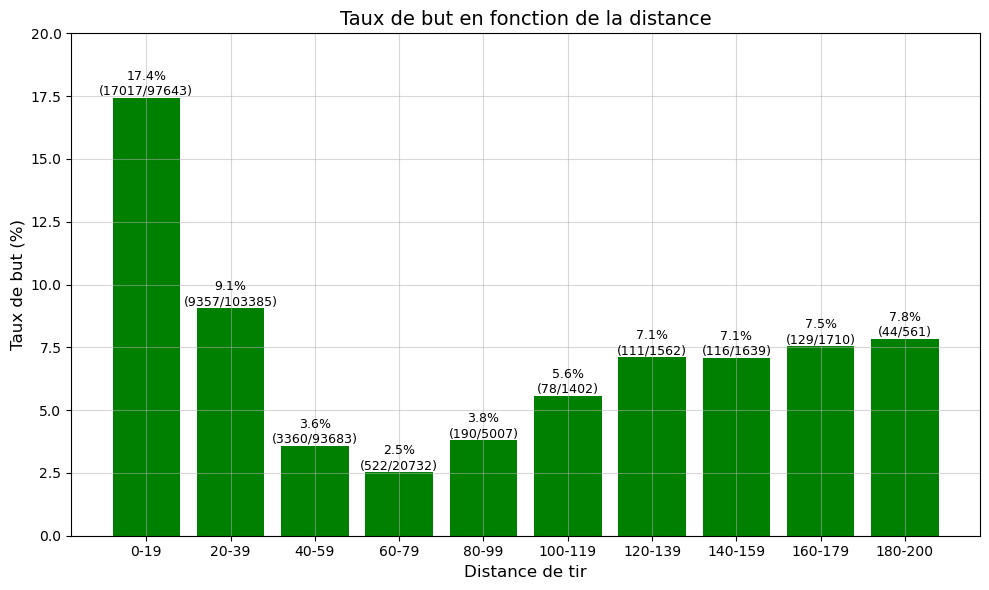

In [16]:
# Tracer la courbe
def plot_goal_rate(df, x, y, rate, rate_min, rate_max, plotTitle, title, fontSize, xlabel, sizeXlabel, ylabel, sizeYlabel):
    # Histogramme
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df.index, df[rate]*100, color='green', label=plotTitle)
    # Annoter les ratios sur les barres
    for bar, (_, row) in zip(bars, df.iterrows()):
        x_i = int(row[x])
        y_i = int(row[y])
        rate_i = row[rate]
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{rate_i*100:.1f}%\n({x_i}/{y_i})",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )
    # Affiche le graphique
    plt.title(title, fontsize=fontSize)
    plt.xlabel(xlabel, fontsize=sizeXlabel)
    plt.ylabel(ylabel, fontsize=sizeYlabel)
    plt.ylim(rate_min, rate_max)  # Limiter l'axe Y
    plt.grid(alpha=0.5)
    # plt.legend()
    plt.tight_layout()
    plt.show()


plot_goal_rate(goal_stats_by_distance, 'goals', 'total_shots', 'goal_rate', 0, 20, 'Taux de but', 'Taux de but en fonction de la distance', 14, 'Distance de tir', 12, 'Taux de but (%)', 12)

In [17]:
# Regrouper les tirs par bins d'angle
goal_stats_by_angle = train_data.groupby('shotAngle_bin', observed=True).agg(
    goals=('isGoal', 'sum'),
    total_shots=('isGoal', 'count')
)

# Calculer le taux de but
goal_stats_by_angle['goal_rate'] = goal_stats_by_angle['goals'] / goal_stats_by_angle['total_shots']

goal_stats_by_angle

,goals,total_shots,goal_rate
shotAngle_bin,,,
0-19,11895,101941,0.116685
20-39,10248,124234,0.082489
40-59,5034,60070,0.083802
60-79,1674,25632,0.065309
80-99,292,5650,0.051681
100-119,94,570,0.164912
120-139,30,126,0.238095
140-159,3,19,0.157895
160-179,6,7,0.857143


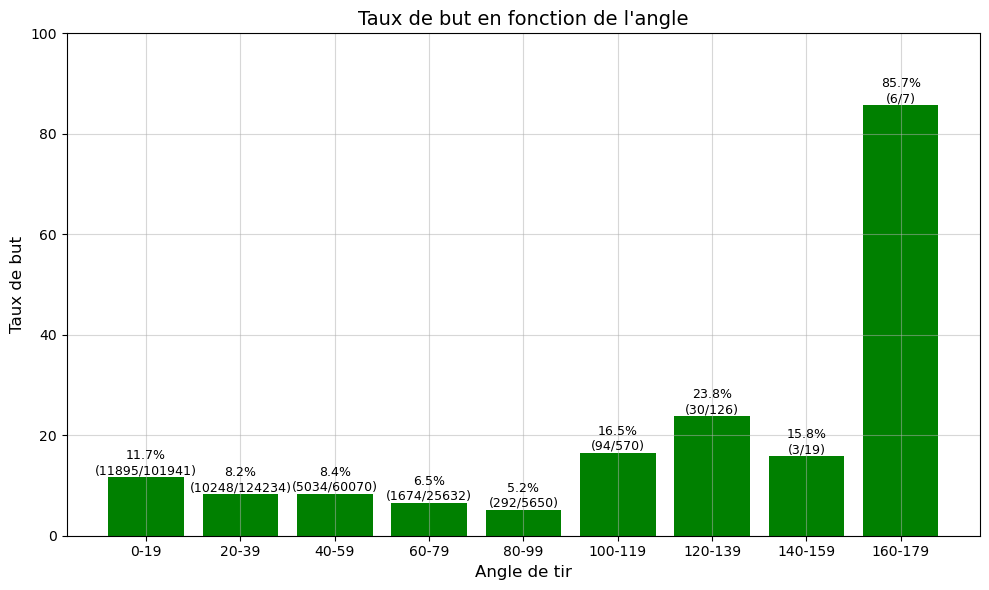

In [18]:
plot_goal_rate(goal_stats_by_angle, 'goals', 'total_shots','goal_rate', 0, 100, 'Taux de but', 'Taux de but en fonction de l\'angle', 14, 'Angle de tir', 12, 'Taux de but', 12)

## Question 3

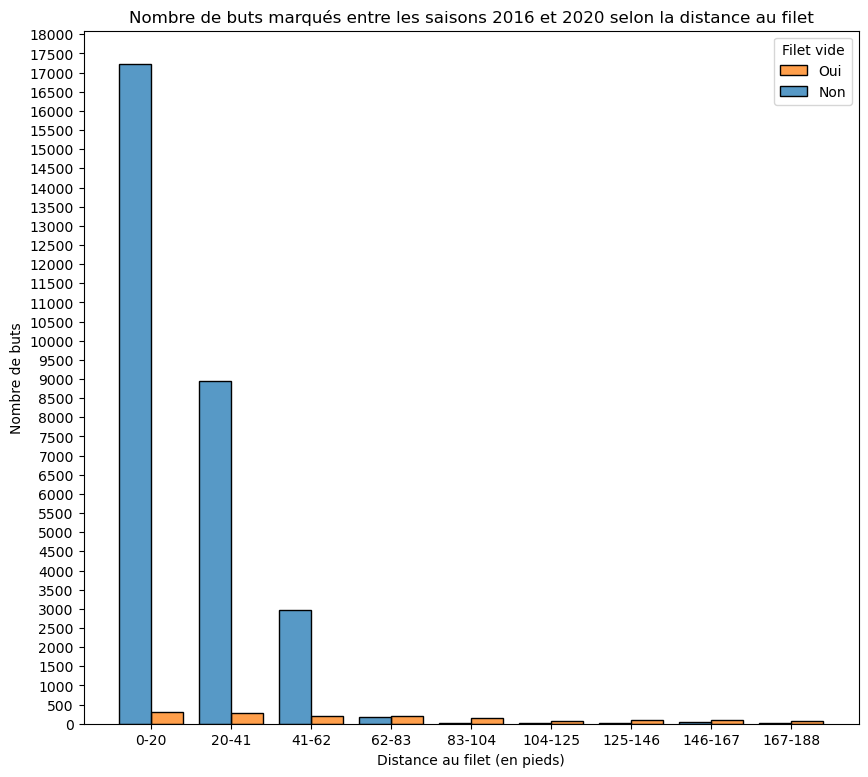

In [19]:
plot_goals_by_distance(train_data)

### Nombre de buts net non vides marqués depuis l'intérieur de la zone défensive

In [20]:
filtered_data = train_data[
    (train_data['shotDistance'] > 90) & (train_data['typeDescKey'] == 'goal') & (train_data['emptyGoalNet'] == 0)]
len(filtered_data)

118

In [21]:
filtered_data.loc[54362, :]

Year                                  2016
idGame                          2016020894
gameType                    regular-season
periodType                              SO
numberPeriod                             5
typeDescKey                           goal
eventOwnerTeam                     Rangers
gameSeconds                           4800
previousEventType             shot-on-goal
timeSinceLastEvent                     0.0
previousXCoord                        74.0
previousYCoord                        -3.0
xCoord                               -71.0
yCoord                                 5.0
zoneShoot                                O
shootingPlayer             Mats Zuccarello
goaliePlayer             Frederik Andersen
shotType                          backhand
teamSide                              away
emptyGoalNet                             0
isGoalAdvantage                  Advantage
isGoal                                   1
shotDistance                         160.1
distanceFro

In [22]:
# l'venement 54362 (filtered_data.loc[54362,:]) du match 2016020894 n'a pas les bonnes coordonées. 
# voir la vidéo: https://www.youtube.com/watch?v=lM6JXVW0-YY du match. le but de Mats Zuccarello en période de shoot-out
# est fait du coté droit, non du coté gauche

# l'evenemnt 80622 du match 2017020004 n'a pas les bonnes coordonées.
# voir la vidéo: https://www.youtube.com/watch?v=WpIGr7srlLY. le but de Kevin Labanc est du mauvais coté

# l'evenemnet 1806 n'a pas le bon zoneShoot/zoneCode. il a comme zoneShoot D (defensive) alors que quand on regarde le but de
# John Tavares, il le marque bien dans la zone offensive https://www.youtube.com/watch?v=MO7vAygX2_c

### Nombre de buts marqués depuis l'intérieur de la zone défensive

In [23]:
filtered_data = train_data[(train_data['shotDistance'] > 90) & (train_data['typeDescKey'] == 'goal')]

grouped_df = filtered_data.groupby(['shotType']).count()

print(grouped_df['idGame'])

shotType
backhand        36
deflected        2
slap            34
snap            41
tip-in          18
wrap-around      1
wrist          437
Name: idGame, dtype: int64


In [24]:
filtered_data[filtered_data['shotType'] == 'wrap-around']

,Year,idGame,gameType,periodType,numberPeriod,typeDescKey,eventOwnerTeam,gameSeconds,previousEventType,timeSinceLastEvent,...,isGoal,shotDistance,distanceFromLastEvent,rebound,speedFromLastEvent,shotAngle,reboundAngleShot,offensivePressureTime,shotDistance_bin,shotAngle_bin
47255,2016,2016020779,regular-season,REG,3,goal,Penguins,3582,takeaway,2.0,...,1,92.0,22.1,False,11.05,0.622756,0.0,101.0,80-99,0-19


In [25]:
# pour l'evenement 47255 du match 2016020779, le type de tir n'est pas correct car un wrap-around ne peut pas se faire aussi loin
# voir: https://www.nhl.com/gamecenter/pit-vs-stl/2017/02/04/2016020779/playbyplay
# video: https://www.youtube.com/watch?v=CHcbWHyRDbE. Sidney Crosby a bien tiré depuis la position (3,1). donc les coordonées et la distance sont 
# bonnes. Le type de tir n'est pas le bon. 

# video wrap-around: https://www.youtube.com/watch?v=tmRibUXW8RE

# Modèles de base

#### Préparation de la caractéristique et de la cible

In [26]:
# Préparation de la caractéristique et de la cible
X = train_data[['shotDistance']].dropna()
y = train_data['isGoal'][X.index]

In [27]:
# Vérification des types et absence de NaN
print(X.shape)
print(y.shape)
print("Type de X:", type(X))
print("Type de y:", type(y))
print("Valeurs manquantes dans X:", X.isnull().sum().sum())
print("Valeurs manquantes dans y:", y.isnull().sum())

(327325, 1)
(327325,)
Type de X: <class 'pandas.core.frame.DataFrame'>
Type de y: <class 'pandas.core.series.Series'>
Valeurs manquantes dans X: 0
Valeurs manquantes dans y: 0


In [28]:
# Division des données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(261860, 1)
(261860,)
(65465, 1)
(65465,)


### Question 1

#### Entraîner le modèle

In [29]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

#### Prédiction et évaluation

In [30]:
# Prédiction et évaluation
y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average="weighted")
print(f"Précision du modèle sur l'ensemble de validation: {accuracy:.2f}")
print(f"F1-score du modèle sur l'ensemble de validation: {f1:.2f}")

Précision du modèle sur l'ensemble de validation: 0.91
F1-score du modèle sur l'ensemble de validation: 0.86


##### Analyse des résultats :
Précision globale :

Une précision élevée ne signifie pas nécessairement que le modèle est performant, surtout si les classes sont déséquilibrées (ex. : beaucoup plus de non-buts que de buts).
Problème potentiel :

La distance seule peut ne pas capturer suffisamment de complexité dans les données pour prédire efficacement si un tir est un but.
Un déséquilibre des classes pourrait conduire à un biais du modèle vers la classe majoritaire.

### Question 2

##### La courbe ROC est tracée avec le taux de vrais positifs (TPR) contre le taux de faux positifs (FPR). La métrique AUC (Area Under Curve) représente l’aire sous cette courbe.

In [31]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay

In [32]:
y_proba = clf.predict_proba(X_val)
# Probabilités pour la classe "but"
y_proba_but = y_proba[:, 1]

# Calcul des ROC et AUC
fpr, tpr, _ = roc_curve(y_val, y_proba_but)
roc_auc = auc(fpr, tpr)

In [33]:
# def plot_roc_curve_(fpr_, tpr_, roc_auc_, color_, label1, label2#, xmin_, xmax_, ymin_, ymax_
#                     ):
#     # Tracé de la courbe ROC
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr_ * 100, tpr_ * 100, color=color_, label = f"{label1} (AUC = {roc_auc_:.2f})")
#     plt.plot([0, 100], [0, 100], linestyle="--", color="gray", label=label2) # Ligne de base du classificateur aléatoire
#     plt.title("Courbe ROC", fontsize=14)
#     plt.xlabel("Taux de faux positifs- FPR (%)", fontsize=12)
#     # plt.xlim(xmin_,xmax_)
#     # plt.xlim(100,0)
#     plt.ylabel("Taux de vrais positifs- TPR (%)", fontsize=12)
#     # plt.ylim(ymin_,ymax_)
#     plt.legend(fontsize=12)
#     plt.grid(alpha=0.3)
#     plt.tight_layout()
#     plt.show()
#
# # Appel de la fonction
# plot_roc_curve_(fpr_=fpr, tpr_=tpr, roc_auc_=roc_auc, color_="blue", label1="Régression logistique", label2="Classificateur aléatoire"
#                 #, xmin_=100, xmax_=0, ymin_=0, ymax_=100
#                 )


##### Courbe ROC et AUC : La courbe ROC permet de visualiser le compromis entre les taux de vrais positifs et de faux positifs, et l'AUC fournit une mesure globale de la performance du modèle.

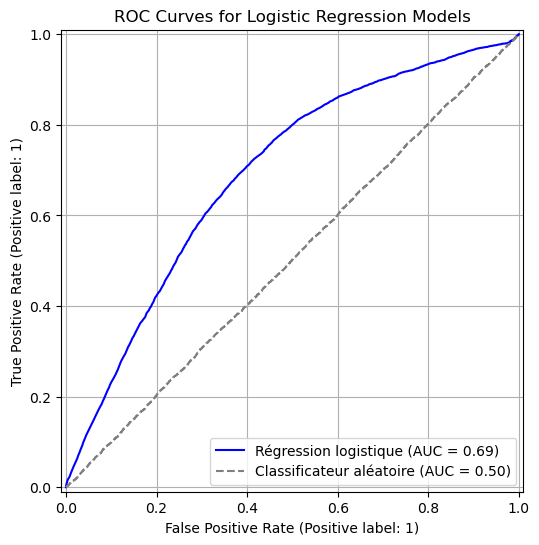

In [36]:
# Ligne de base aléatoire
y_proba_random = np.random.uniform(0, 1, len(y_val))
plt.figure(figsize=(10, 6))
# ROC
RocCurveDisplay.from_predictions(y_val, y_proba_but, name="Régression logistique", color="blue", ax=plt.gca())
RocCurveDisplay.from_predictions(y_val, y_proba_random, name="Classificateur aléatoire", color="gray", linestyle="--", ax=plt.gca())
plt.title("ROC Curves for Logistic Regression Models")
plt.grid(True)
plt.show()

#### b) Taux de buts par centile de probabilité

##### Cette courbe montre la capacité du modèle à prédire des buts en fonction de la probabilité qu'il attribue à chaque tir.
Pour tracer le taux de buts par centile de probabilité, nous devons analyser la proportion de tirs qui se sont effectivement transformés en buts dans chaque centile des probabilités prédites par le modèle.

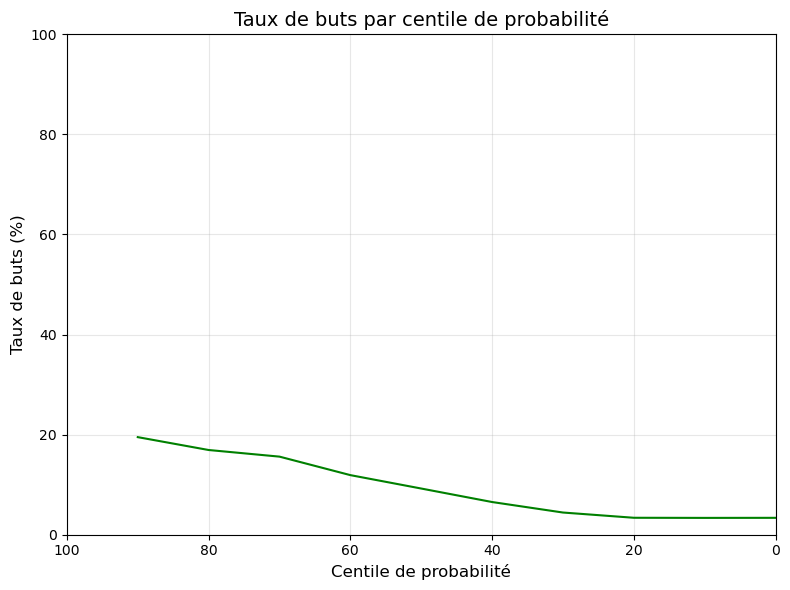

In [37]:
percentiles = np.linspace(0, 100, 11)
goal_rates = compute_goal_rate_by_percentile(y_val, y_proba_but, percentiles)

plot_line_2_variables(x=percentiles[:-1], y=goal_rates, color='green', label="Taux de buts par centile de probabilité", xinf=100, xsup=0, x_label="Centile de probabilité", y_label="Taux de buts (%)")

##### Cette courbe montre la capacité du modèle à prédire des buts en fonction de la probabilité qu'il attribue à chaque tir.

#### c) La proportion cumulée de buts (pas de tirs) comme une fonction du centile de la probabilité de tir donnée par le modèle

##### Elle montre dans quelle mesure chaque modèle capture les buts les plus probables.

In [39]:
def compute_cumulative_goal_rate_2(y_proba, event):
    # Créer un DataFrame pour les probabilités de tir
    df_probs = pd.DataFrame(y_proba)

    # Combiner la probabilité de but avec la colonne "isGoal"
    df_probs = pd.concat([df_probs[event].reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)

    # Calculer et ajouter une colonne pour les percentiles
    percentile_values = df_probs[event].rank(pct=True)
    df_probs['Percentile'] = percentile_values * 100
    taux_cumul = df_probs.copy()

    taux_cumul_but = taux_cumul[taux_cumul['isGoal'] == 1]

    return taux_cumul_but


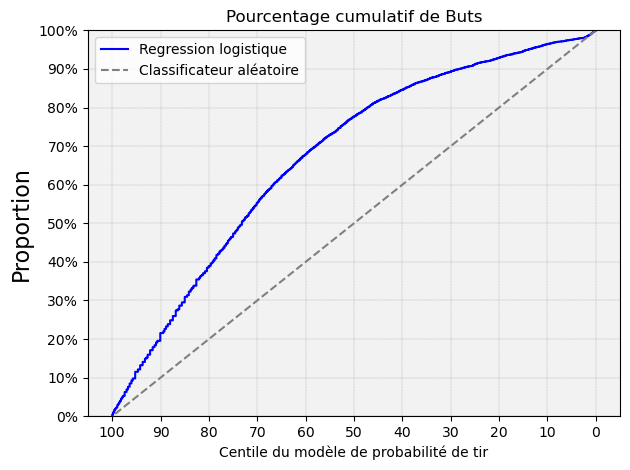

In [42]:
taux_cumul_but = compute_cumulative_goal_rate_2(y_proba, 1)

sns.ecdfplot(data=taux_cumul_but, x=100 - taux_cumul_but.Percentile, color='blue', label="Regression logistique")

plt.plot([100, 0], [1, 0], linestyle="--", color="gray", label="Classificateur aléatoire") # Ligne de base du Classificateur aléatoire

# Personnalisation du graphique
ax = plt.gca()
ax.grid()
ax.set_facecolor('0.95')
plt.yticks(np.arange(0, 1.05, 0.1))
plt.xticks(np.arange(0, 100 * 1.01, 10))
xvals = ax.get_xticks()
ax.set_xticklabels(100 - xvals.astype(int), fontsize=10)
yvals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(y) for y in yvals], fontsize=10)
ax.set_xlabel('Centile du modèle de probabilité de tir', fontsize=10)
ax.set_ylabel('Proportion', fontsize=16)
ax.set_title("Pourcentage cumulatif de Buts", fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.2)
plt.legend(fontsize=10)
plt.tight_layout()
# plt.savefig('2-3-3c_proportion_de_buts.png')
plt.show()

#### d) Le diagramme de fiabilité (courbe de calibration)

In [ ]:
# 4. Diagramme de fiabilité
CalibrationDisplay.from_predictions(y_val, y_proba, n_bins=10)
plt.title("Diagramme de fiabilité")
plt.show()

In [ ]:
CalibrationDisplay.from_estimator(clf, X_val, y_val)
plt.title('Courbe de Calibration', fontsize=14)
plt.show()

### Question 3 : Entrainement de deux autres classificateurs
- Distance seuelement
- Angle seulement
- Distance et angle

In [ ]:
# Préparation de la caractéristique et de la cible
X_2 = train_data[['shotDistance', 'shotAngle']].dropna()
y_2 = train_data['isGoal'][X.index]

In [ ]:
# Vérification des types et absence de NaN
print("Type de X:", type(X_2))
print("Type de y:", type(y_2))
print("Valeurs manquantes dans X:", X_2.isnull().sum().sum())
print("Valeurs manquantes dans y:", y_2.isnull().sum())

In [ ]:
# Division des données en ensembles d'entraînement et de validation
X2_train, X2_val, y2_train, y2_val = train_test_split(X_2, y_2, test_size=0.2, random_state=42,stratify=y_2)

In [ ]:
# Charger les caractéristiques pour chaque ensemble de données
# La distance seulement
X2_distance_train = X2_train[['shotDistance']]
X2_distance_val = X2_val[['shotDistance']]
# L'angle seulement
X2_angle_train = X2_train[['shotAngle']]
X2_angle_val = X2_val[['shotAngle']]
# La distance et l'angle
X2_both_train = X2_train[['shotDistance','shotAngle']]
X2_both_val = X2_val[['shotDistance','shotAngle']]

In [ ]:
print(X2_distance_train.shape)
print(X2_distance_val.shape)
print(X2_angle_train.shape)
print(X2_angle_val.shape)

In [ ]:
# Entraînement des modèles
clf_distance = LogisticRegression().fit(X2_distance_train, y2_train)
clf_angle = LogisticRegression().fit(X2_angle_train, y2_train)
clf_both = LogisticRegression().fit(X2_both_train, y2_train)

# Probabilités prédites pour chaque modèle
y_proba_distance = clf_distance.predict_proba(X2_distance_val)
y_proba_angle = clf_angle.predict_proba(X2_angle_val)
y_proba_both = clf_both.predict_proba(X2_both_val)

y_proba_but_distance = y_proba_distance[:, 1]
y_proba_but_angle = y_proba_angle[:, 1]
y_proba_but_both = y_proba_both[:, 1]

# Ligne de base aléatoire
y2_proba_random = np.random.uniform(0, 1, len(y2_val))

#### a) Courbe ROC avec AUC

In [ ]:
# Tracer les courbes ROC
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_predictions(y2_val, y_proba_distance, name="Distance", color="blue", ax=plt.gca())
RocCurveDisplay.from_predictions(y2_val, y_proba_angle, name="Angle", color="green", ax=plt.gca())
RocCurveDisplay.from_predictions(y2_val, y_proba_both, name="Distance + Angle", color="red", ax=plt.gca())
RocCurveDisplay.from_predictions(y2_val, y2_proba_random, name="Random Baseline", color="gray", linestyle="--", ax=plt.gca())

plt.title("ROC Curves for Logistic Regression Models")
plt.grid(True)
plt.show()

#### b) Taux de buts par centile

In [ ]:
# Calculer les taux pour chaque modèle
# centiles = np.linspace(100, 0, 100)  # Centiles décroissants
goal_rate_distance = compute_goal_rate_by_percentile(y_val, y_proba_distance, percentiles)
goal_rate_angle = compute_goal_rate_by_percentile(y_val, y_proba_angle, percentiles)
goal_rate_both = compute_goal_rate_by_percentile(y_val, y_proba_both, percentiles)
goal_rate_random = compute_goal_rate_by_percentile(y_val, y_proba_random, percentiles)

# Tracer les taux de buts
plt.figure(figsize=(10, 6))
plt.plot(percentiles[:-1], goal_rate_distance, label="Distance", color="blue")
plt.plot(percentiles[:-1], goal_rate_angle, label="Angle", color="green")
plt.plot(percentiles[:-1], goal_rate_both, label="Distance + Angle", color="red")
plt.plot(percentiles[:-1], goal_rate_random, label="Random Baseline", color="black", linestyle="--")

# Personnalisation du graphique
ax = plt.gca()
ax.grid()
ax.set_facecolor('0.95')

ax.set_ylim([0, 100])
ax.set_xlim([0, 100])
ax.invert_xaxis()
major_ticks = np.arange(0, 110, 10)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)

plt.title("Taux de buts par centile de probabilité")
plt.xlabel("Centile de probabilité")
# plt.xlim(100,0)
plt.ylabel("Taux de buts (%)")
# plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.show()


#### c) Proportion cumulée des buts par centile

In [ ]:
# Calculer les proportions cumulées pour chaque modèle
cumulative_goals_distance_but = compute_cumulative_goal_rate_2(y_proba_distance, 1)

cumulative_goals_angle_but = compute_cumulative_goal_rate_2(y_proba_angle, 1)

cumulative_goals_both_but = compute_cumulative_goal_rate_2(y_proba_both, 1)

sns.ecdfplot(data=cumulative_goals_distance_but, x=100 - cumulative_goals_distance_but.Percentile, label="Distance", color='blue')

sns.ecdfplot(data=cumulative_goals_angle_but, x=100 - cumulative_goals_distance_but.Percentile, label="Angle", color='green')

sns.ecdfplot(data=cumulative_goals_both_but, x=100 - cumulative_goals_both_but.Percentile, label="Distance + Angle", color='red')

plt.plot([100, 0], [1, 0], linestyle="--", color="gray", label="Classificateur aléatoire") # Ligne de base du Classificateur aléatoire

# Personnalisation du graphique
ax = plt.gca()
ax.grid()
ax.set_facecolor('0.95')
plt.yticks(np.arange(0, 1.05, 0.1))
plt.xticks(np.arange(0, 100 * 1.01, 10))
xvals = ax.get_xticks()
ax.set_xticklabels(100 - xvals.astype(int), fontsize=16)
yvals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(y) for y in yvals], fontsize=16)
ax.set_xlabel('Centile du modèle de probabilité de tir', fontsize=16)
ax.set_ylabel('Proportion', fontsize=16)
ax.set_title("Pourcentage cumulatif de Buts", fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.2)

plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('2-3-3c_proportion_de_buts.png')
plt.show()


#### d) Diagramme de fiabilité

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

CalibrationDisplay.from_predictions(y2_val, y_proba_distance, n_bins=10, ax=ax, name="Reg log : distance")
CalibrationDisplay.from_predictions(y2_val, y_proba_angle, n_bins=10, ax=ax, name="Reg log : angle")
CalibrationDisplay.from_predictions(y2_val, y_proba_both, n_bins=10, ax=ax, name="Reg log : both")

plt.title("Diagramme de fiabilité")
plt.show()

NameError: name 'plt' is not defined

### Question 4: WandB

In [ ]:
import os
os.environ["WANDB_DIR"] = "C:/DS_milestone2_wandb"
os.environ["WANDB_NOTEBOOK_NAME"] = "main_Milestone-2.ipynb"

#### wandb pour distance seulement

In [ ]:
# Initialiser Wandb pour distance
run = wandb.init(
    project=config.WANDB_PROJECT_NAME,  # Nom du projet
    name="LogisticRegression_Distance",  # Nom de l'expérience
    group="logistic_regression",
    tags=["logistic_regression", "distance_only"],  # Tags pour cette expérience
    entity=config.WANDB_TEAM_NAME
)

# Exemple : Entraîner le modèle
clf1 = LogisticRegression()
clf1.fit(X2_distance_train, y2_train)

# Évaluer le modèle (exemple avec AUC ROC)
y_proba1 = clf1.predict_proba(X2_distance_val)[:, 1]
auc_roc1 = roc_auc_score(y2_val, y_proba1)

y_predict1 = clf1.predict(X2_distance_val)

auc_roc = roc_auc_score(y_val_advanced_2, y_predicted_prob_advanced_2)
f1 = f1_score(y_predicted_advanced_2, y_val_advanced_2, average="weighted")
ece = compute_ece(y_val_advanced_2, y_predicted_prob_advanced_2)

# Enregistrer les métriques dans Wandb
wandb.log({"val_roc_auc": auc_roc, "val_f1_score_weighted": f1, "val_expected_calibration_error": ece })

model_path = "LogisticRegression_Distance.pkl"
with open(model_path, "wb") as f:
    pickle.dump(clf1, f)

# Enregistrer le modèle avec WandB
run.log_model(path="LogisticRegression_Distance.pkl", name="LogisticRegression_Distance")

# Terminer l'expérience
wandb.finish()

#### wandb pour angle seulement

In [ ]:
# Initialiser Wandb
wandb.init(
    project=config.WANDB_PROJECT_NAME,
    dir="C:/DS_milestone2_wandb",
    name="LogisticRegression_Angle",  # Nom de l'expérience
    group="logistic_regression",
    tags=["logistic_regression", "angle_only"],  # Tags pour cette expérience
    entity=config.WANDB_TEAM_NAME
)

# Exemple : Entraîner le modèle
clf2 = LogisticRegression()
clf2.fit(X2_angle_train, y2_train)

# Évaluer le modèle (exemple avec AUC ROC)
y_proba2 = clf2.predict_proba(X2_angle_val)[:, 1]
auc_roc2 = roc_auc_score(y2_val, y_proba2)

# Enregistrer les métriques dans Wandb
wandb.log({"val_roc_auc": auc_roc2})

# Sauvegarder le modèle
model_path2 = "logistic_regression_angle.pkl"
with open(model_path2, "wb") as f2:
    pickle.dump(clf2, f2)

# Enregistrer le modèle dans Wandb
wandb.save(model_path2)

# Terminer l'expérience
wandb.finish()

#### wandb: Distance et angle

In [ ]:
# Initialiser Wandb
wandb.init(
    project=config.WANDB_PROJECT_NAME,
    dir="C:/DS_milestone2_wandb",
    name="LogisticRegression_Distance_Angle",  # Nom de l'expérience
    group="logistic_regression",
    tags=["logistic_regression", "distance et angle"],  # Tags pour cette expérience
    entity=config.WANDB_TEAM_NAME
)

# Exemple : Entraîner le modèle
clf3 = LogisticRegression()
clf3.fit(X2_both_train, y2_train)

# Évaluer le modèle (exemple avec AUC ROC)
y_proba3 = clf3.predict_proba(X2_both_val)[:, 1]
auc_roc3 = roc_auc_score(y2_val, y_proba3)

# Enregistrer les métriques dans Wandb
wandb.log({"val_roc_auc": auc_roc3})

# Sauvegarder le modèle
model_path3 = "logistic_regression_distance_and_angle.pkl"
with open(model_path3, "wb") as f3:
    pickle.dump(clf3, f3)

# Enregistrer le modèle dans Wandb
wandb.save(model_path3)

# Terminer l'expérience
wandb.finish()

# Ingénierie des caractéristiques II

### Ajout de l'artefact sur Wandb

In [ ]:
# Connect to the Wandb API
api = wandb.Api()

# Spécifiez votre projet
project_name = config.WANDB_PROJECT_NAME
entity = config.WANDB_TEAM_NAME

try:
    artifact = api.artifact(f'{entity}/{project_name}/wpg_v_wsh_2017021065:latest')
    print("L'artefact existe déjà.")
except wandb.errors.CommError as e:
    run = wandb.init(project="IFT6758.2024-A11")

    # Create artefact
    artifact = wandb.Artifact(
        "wpg_v_wsh_2017021065",
        type="dataset"
    )

    # add data
    my_table = wandb.Table(dataframe=train_data[train_data['idGame'] == 2017021065])
    artifact.add(my_table, "wpg_v_wsh_2017021065")
    run.log_artifact(artifact)


# Modèles avancés 

## Question 1

### Entrainement du modèle

In [ ]:
# Sélection des caractéristiques
xgb_basic_characteristics = ['shotDistance', 'shotAngle']

x = train_data[xgb_basic_characteristics].dropna()
y = train_data['isGoal'][x.index]

In [ ]:
x_train_basic, x_val_basic, y_train_basic, y_val_basic = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(x_train_basic, y_train_basic)

### Courbes

#### ROC/AUC

In [ ]:
# Probabilités pour la classe "but"
y_predicted_prob_basic = xgb.predict_proba(x_val_basic)[:, 1]

In [ ]:
# Ligne de base aléatoire
y_proba_random = np.random.uniform(0, 1, len(y_val_basic))
plt.figure(figsize=(10, 6))
# ROC
RocCurveDisplay.from_predictions(y_val_basic, y_predicted_prob_basic, name="XGBoost", color="blue", ax=plt.gca())
RocCurveDisplay.from_predictions(y_val_basic, y_proba_random, name="Classificateur aléatoire", color="gray", linestyle="--", ax=plt.gca())
plt.title("ROC Curve for XGBoost Model")
plt.grid(True)
plt.show()
# plt.savefig('modele_avance_q1_roc.png', dpi=300)

In [ ]:
# le XGBoost a un AUC similaire a celui de la regression logistique (entrainée avec l'angle et la distance) 

#### Taux de buts vs percentile de probabilité 

In [ ]:
percentiles = np.linspace(0, 100, 11)
goal_rates = compute_goal_rate_by_percentile(y_val_basic, y_predicted_prob_basic, percentiles)

plot_line_2_variables(x=percentiles[:-1], y=goal_rates, color='green', label="Taux de buts par centile des probabilités prédites", xinf=100, xsup=0, x_label="Centiles des probabilités prédites", y_label="Taux de buts (%)")

In [ ]:
# il s'agit d'une courbe de calibrage personnalisé. la courbe monte régulièrement, cela signifie  cela signifie que les probabilités prédites 
# par le modèle sont cohérentes avec les fréquences observées
# La courbe est similaire a celle de la reg logistique distance + angle

#### Proportion cumulée de buts vs percentile de probabilité

#### Le diagramme de fiabilité (courbe de calibration)

In [ ]:
CalibrationDisplay.from_predictions(y_val_basic, y_predicted_prob_basic, n_bins=10, name="XGBoost basique")
plt.title("Diagramme de fiabilité")
plt.show()

In [ ]:
# la courbe passe en dessous de la diagonale a partir de 0.4 environ, 
# ainsi, cette figure pourrait impliquerait que le modèle sur-prédit les probabilités. cependant, sachant qu'il n,ya pas peu
#etre pas assez de données dans les bins, on est mieux de se fier a la courbe de buts par percentile qu'on a faite qui a aplus de données
#par bin (la fraction de valeurs positive dans chaque bin est donc plus representative )

#La courbe est cohérente au début (où il y a beaucoup d'exemples) mais devient incohérente aux extrémités (où les bins sont sous-représentés)
# ici le modele surprédit, alors que dans le cas de la regression logistique, le modèle sous-predit

### Wandb

In [ ]:
# Initialiser Wandb pour distance
wandb.init(
    project=config.WANDB_PROJECT_NAME,  # Nom du projet
    name="XGBoost par défaut : distance et angle",  # Nom de l'expérience
    group="XGBoost",
    tags=["XGBoost", "distance_and_angle"],  # Tags pour cette expérience
    entity=config.WANDB_TEAM_NAME
)

xgb_params = {
    "learning_rate": 0.3,
    "max_depth": 6,
    "n_estimators": 100,
    "subsample": 1.0
}

# Logger les hyperparamètres dans wandb
wandb.config.update(xgb_params)

y_predicted_basic = xgb.predict(x_val_basic)

auc_roc = roc_auc_score(y_val_basic, y_predicted_prob_basic)
f1 = f1_score(y_predicted, y_val_basic, average="weighted")
ece = compute_ece(y_val_basic, y_predicted_prob_basic)

# Enregistrer les métriques dans Wandb
wandb.log({"val_roc_auc": auc_roc, "val_f1_score_weighted": f1, "val_expected_calibration_error": ece })

# Terminer l'expérience
wandb.finish()

## Question 2

In [ ]:
xgb_categorial_characteristics = [
    'shotType',
    'previousEventType',
    'rebound'
]

xgb_num_characteristics = ['shotDistance', 
                   'shotAngle', 
                   'numberPeriod', 
                   'gameSeconds',
                   'xCoord',
                   'yCoord',
                   'previousXCoord',
                   'previousYCoord',
                   'timeSinceLastEvent',
                   'distanceFromLastEvent',
                   'speedFromLastEvent',
                  'reboundAngleShot' # changement angle de tir
                  ]

characteristics = xgb_num_characteristics + xgb_categorial_characteristics

In [ ]:
x_full_train = train_data[characteristics].dropna()
y_full_train = train_data['isGoal'][x_full_train.index].to_numpy()

In [ ]:
full_pipeline = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), xgb_categorial_characteristics),  # OneHotEncoder pour les colonnes catégorielles
    ],
    remainder="passthrough"  # Garder les autres colonnes telles quelles
)

# Appliquer la pipeline aux données
x_full_train_transformed = full_pipeline.fit_transform(x_full_train)

### Optimisation des hyperparamètres

In [ ]:
from sklearn.metrics import make_scorer

'''
def compute_ece(y_true, y_proba, n_bins=10):
    """
    Calcule l'Expected Calibration Error (ECE).
    
    Args:
        y_true: array, étiquettes vraies (0 ou 1).
        y_proba: array, probabilités prédites pour la classe positive.
        n_bins: int, nombre de bins pour la calibration.
        
    Returns:
        ece: erreur de calibration moyenne attendue.
    """
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_proba, bins, right=True) - 1
    ece = 0.0

    for i in range(n_bins):
        # Masque des exemples dans le bin courant
        bin_mask = bin_indices == i
        if bin_mask.sum() > 0:
            bin_mean_predicted = y_proba[bin_mask].mean()
            bin_actual = y_true[bin_mask].mean()
            ece += (bin_mask.sum() / len(y_true)) * abs(bin_mean_predicted - bin_actual)
    
    return ece

# Créer une version négative de l'ECE pour minimisation
def negative_ece(y_true, y_proba):
    return -compute_ece(y_true, y_proba)

ece_scorer = make_scorer(negative_ece, needs_proba=True)

xgb = XGBClassifier(objective='binary:logistic')

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "learning_rate": [0.01, 0.1],        # Taux d'apprentissage
    "max_depth": [10, 20],                  # Profondeur maximale des arbres
    "n_estimators": [200, 300],          # Nombre d'arbres
    "subsample": [0.7, 1.0],                 # Proportion des échantillons utilisés par arbre
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=ece_scorer,
    cv=stratified_cv,                                   # Nombre de folds pour la validation croisée
    verbose=1,                              # Niveau de log
    n_jobs=-1                               # Utilisation de tous les cœurs disponibles
)

grid_search.fit(x_full_train_transformed, y_full_train)

# Résultats de la meilleure combinaison d'hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score (Brier Score) :", grid_search.best_score_)


# show_xgboost_hyperparameters_scores(grid_search)
'''

### Courbes XGBoost

In [ ]:
xgb_basic = XGBClassifier(objective='binary:logistic')

# grid_search.best_params_
# best_params = {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 300, 'subsample': 1.0}
best_params = {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'subsample': 1.0}

xgb_advanced = XGBClassifier(objective='binary:logistic', **best_params)

x = train_data[characteristics].dropna()
y = train_data['isGoal'][x.index]

x_train_advanced, x_val_advanced, y_train_advanced, y_val_advanced = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
xgb_basic.fit(x_train_basic, y_train_basic)

x_train_advanced = full_pipeline.fit_transform(x_train_advanced)
x_val_advanced = full_pipeline.fit_transform(x_val_advanced)

xgb_advanced.fit(x_train_advanced, y_train_advanced)

y_predicted_prob_basic = xgb_basic.predict_proba(x_val_basic)[:, 1]
y_predicted_prob_advanced = xgb_advanced.predict_proba(x_val_advanced)[:, 1]

#### ROC/AUC

In [ ]:
plt.figure(figsize=(15, 8))
RocCurveDisplay.from_predictions(y_val_basic, y_predicted_prob_basic, name="XGBoost basique (Distance et angle)", color="blue", ax=plt.gca())
RocCurveDisplay.from_predictions(y_val_advanced, y_predicted_prob_advanced, name="XGBoost avancé - caractéristiques nouvelles", color="green", ax=plt.gca())

plt.title("ROC Curves for XGBoost Models")
plt.grid(True)
plt.show()

#### Taux de buts vs percentile de probabilité

In [ ]:
goal_rate_basic = compute_goal_rate_by_percentile(y_val_basic, y_predicted_prob_basic, percentiles)
goal_rate_advanced = compute_goal_rate_by_percentile(y_val_advanced, y_predicted_prob_advanced, percentiles)

# Tracer les taux de buts
plt.figure(figsize=(10, 6))
plt.plot(percentiles[:-1], goal_rate_basic, label="XGBoost basique", color="blue")
plt.plot(percentiles[:-1], goal_rate_advanced, label="XGBoost avancé - caractéristiques nouvelles", color="green")

plt.title("Taux de buts par centile de probabilité")
plt.xlabel("Centile de probabilité")
plt.xlim(100,0)
plt.ylabel("Taux de buts (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.show()

#### Proportion cumulée des buts par centile

#### Diagramme de fiabilité

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

CalibrationDisplay.from_predictions(y_val_basic, y_predicted_prob_basic, n_bins=10, ax=ax, name="XGBoost basique")
CalibrationDisplay.from_predictions(y_val_advanced, y_predicted_prob_advanced, n_bins=10, ax=ax, name="XGBoost avancé - caractéristiques nouvelles")

plt.title("Diagramme de fiabilité")
plt.show()

### wandb

In [ ]:
run = wandb.init(
    project=config.WANDB_PROJECT_NAME,  # Nom du projet
    name="XGBoost avancé (nouvelles caractéristiques)",  # Nom de l'expérience
    group="XGBoost",
    tags=["XGBoost", "new_features"],  # Tags pour cette expérience
    entity=config.WANDB_TEAM_NAME
)

xgb_params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'n_estimators': 300,
    'subsample': 1.0
}

# Logger les hyperparamètres dans wandb
wandb.config.update(xgb_params)

y_predicted_advanced = xgb_advanced.predict(x_val_advanced)

auc_roc = roc_auc_score(y_val_advanced, y_predicted_prob_advanced)
f1 = f1_score(y_predicted_advanced, y_val_advanced, average="weighted")
ece = compute_ece(y_val_advanced, y_predicted_prob_advanced)

wandb.log({"val_roc_auc": auc_roc, "val_f1_score_weighted": f1, "val_expected_calibration_error": ece })

model_path = "XGBoost_improved_with_new_features.pkl"
with open(model_path, "wb") as f:
    pickle.dump(xgb_advanced, f)

# Enregistrer le modèle avec WandB
run.log_model(path="XGBoost_improved_with_new_features.pkl", name="XGBoost_improved_with_new_features")

# Terminer l'expérience
wandb.finish()

## Question 3

### Sélection par importances via forêt aléatoire

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score

In [ ]:
x_full_train = train_data[characteristics].dropna()
y_full_train = train_data['isGoal'][x_full_train.index].to_numpy()

x_full_train_transformed = full_pipeline.fit_transform(x_full_train)

In [ ]:
'''
clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
clf.fit(x_full_train_transformed, y_full_train)

# Obtenir l'importance des caractéristiques
importances = clf.feature_importances_

# Définir plusieurs seuils pour les importances
thresholds = np.linspace(0, max(importances), 10)

print(min(importances), max(importances)) # 0.0005237490370182553 0.10476373782698718

# Initialiser les variables pour suivre les scores et les seuils
scores_by_threshold = []

# Définir une validation croisée stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Essayer plusieurs seuils pour sélectionner les meilleures caractéristiques
for threshold in thresholds:
    # Sélectionner les caractéristiques importantes
    selector = SelectFromModel(clf, threshold=threshold, prefit=True)
    
    x_train_selected = selector.transform(x_full_train_transformed)

    xgb_advanced = XGBClassifier(objective='binary:logistic', **best_params)

    # Calculer la moyenne des scores sur les plis de la validation croisée
    scores = cross_val_score(xgb_advanced, x_train_selected, y_full_train, cv=cv, scoring=make_scorer(negative_ece, needs_proba=True))
    mean_score = np.mean(scores)

    # Stocker les résultats
    scores_by_threshold.append((threshold, mean_score))
    print(f"Threshold: {threshold:.4f}, Cross-Validation negative ECE: {mean_score:.4f}")

ece_by_threshold = [(t[0], t[1] * -1) for t in scores_by_threshold]

# Extraire les valeurs pour l'axe x (étiquettes) et l'axe y (hauteur des barres)
thresholds = [x[0] for x in ece_by_threshold]
ece_values = [x[1] for x in ece_by_threshold]

# Créer le graphique en bâtons
plt.figure(figsize=(10, 6))
plt.bar(thresholds, ece_values, width=0.003, color='skyblue')

# Ajouter les étiquettes
plt.xlabel('Threshold')
plt.ylabel('Erreur de calibration moyenne')
plt.title('Graphique en bâtons des Thresholds et des érreurs de calibration attendues moyennes')

# Afficher les étiquettes des thresholds sur l'axe des x
plt.xticks(thresholds, rotation=45)

# Afficher le graphique
plt.tight_layout()
plt.grid()
plt.savefig('modele_avance_q3_feature_selection_random_forest.png', dpi=300)
plt.show()
'''

In [ ]:
# best_threshold = sorted(ece_by_threshold, key=lambda x: x[1])[0][0] . celui qui minimise l'érruer de calibration
best_threshold = 0.08148290719876781

In [ ]:
clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
clf.fit(x_full_train_transformed, y_full_train)

selector = SelectFromModel(clf, threshold=best_threshold, prefit=True)

In [ ]:
ohe = full_pipeline.named_transformers_["cat"]
ohe_columns = ohe.get_feature_names_out(xgb_categorial_characteristics)

# Colonnes "passthrough" (non modifiées)
passthrough_columns = xgb_num_characteristics

# Liste finale des colonnes
all_columns = list(ohe_columns) + passthrough_columns
all_columns_array = np.array(all_columns)

print("colonnes conservées")
print(all_columns_array[selector.get_support()])
'''
['shotDistance' 'shotAngle' 'gameSeconds' 'xCoord' 'yCoord'
 'timeSinceLastEvent' 'distanceFromLastEvent' 'speedFromLastEvent']
'''

In [ ]:
x_train_advanced_2, x_val_advanced_2, y_train_advanced_2, y_val_advanced_2 = train_test_split(x_full_train, y_full_train, test_size=0.2, random_state=42, stratify=y_full_train)

xgb_advanced_2 = XGBClassifier(objective='binary:logistic', **best_params)

x_train_advanced_2 = full_pipeline.fit_transform(x_train_advanced_2)
x_train_advanced_2 = selector.transform(x_train_advanced_2)

x_val_advanced_2 = full_pipeline.fit_transform(x_val_advanced_2)
x_val_advanced_2 = selector.transform(x_val_advanced_2)

xgb_advanced_2.fit(x_train_advanced_2, y_train_advanced_2)

y_predicted_prob_advanced_2 = xgb_advanced_2.predict_proba(x_val_advanced_2)[:, 1]

#### ROC/AUC

In [ ]:
plt.figure(figsize=(15, 8))
RocCurveDisplay.from_predictions(y_val_basic, y_predicted_prob_basic, name="XGBoost basique (Distance et angle)", color="blue", ax=plt.gca())
RocCurveDisplay.from_predictions(y_val_advanced, y_predicted_prob_advanced, name="XGBoost avancé - caractéristiques nouvelles", color="green", ax=plt.gca())
RocCurveDisplay.from_predictions(y_val_advanced_2, y_predicted_prob_advanced_2, name="XGBoost avancé - caractéristiques sélectionnées", color="red", ax=plt.gca())

plt.title("ROC Curves for XGBoost Models")
plt.grid(True)
plt.savefig('modele_avance_q3_roc.png', dpi=300)
plt.show()

#### Taux de buts vs percentile de probabilité

In [ ]:
goal_rate_basic = compute_goal_rate_by_percentile(y_val_basic, y_predicted_prob_basic, percentiles)
goal_rate_advanced = compute_goal_rate_by_percentile(y_val_advanced, y_predicted_prob_advanced, percentiles)
goal_rate_advanced_2 = compute_goal_rate_by_percentile(y_val_advanced_2, y_predicted_prob_advanced_2, percentiles)


# Tracer les taux de buts
plt.figure(figsize=(10, 6))
plt.plot(percentiles[:-1], goal_rate_basic, label="XGBoost basique", color="blue")
plt.plot(percentiles[:-1], goal_rate_advanced, label="XGBoost avancé - caractéristiques nouvelles", color="green")
plt.plot(percentiles[:-1], goal_rate_advanced_2, label="XGBoost avancé - caractéristiques sélectionnées", color="red")


plt.title("Taux de buts par centile de probabilité")
plt.xlabel("Centile de probabilité")
plt.xlim(100,0)
plt.ylabel("Taux de buts (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.savefig('modele_avance_q3_goal_rate.png', dpi=300)
plt.show()

#### Proportion cumulée des buts par centile

#### Diagramme de fiabilité

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

CalibrationDisplay.from_predictions(y_val_basic, y_predicted_prob_basic, n_bins=10, ax=ax, name="XGBoost basique")
CalibrationDisplay.from_predictions(y_val_advanced, y_predicted_prob_advanced, n_bins=10, ax=ax, name="XGBoost avancé - caractéristiques nouvelles")
CalibrationDisplay.from_predictions(y_val_advanced_2, y_predicted_prob_advanced_2, n_bins=10, ax=ax, name="XGBoost avancé - caractéristiques sélectionnées")

plt.title("Diagramme de fiabilité")
plt.savefig('modele_avance_q3_reliability_diagram.png', dpi=300)
plt.show()

### Wandb

In [ ]:
run = wandb.init(
    project=config.WANDB_PROJECT_NAME,  # Nom du projet
    name="XGBoost avancé (caractéristiques selectionnées)",  # Nom de l'expérience
    group="XGBoost",
    tags=["XGBoost", "selected_features"],  # Tags pour cette expérience
    entity=config.WANDB_TEAM_NAME
)

xgb_params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'n_estimators': 300,
    'subsample': 1.0
}

# Logger les hyperparamètres dans wandb
wandb.config.update(xgb_params)

y_predicted_advanced_2 = xgb_advanced_2.predict(x_val_advanced_2)

auc_roc = roc_auc_score(y_val_advanced_2, y_predicted_prob_advanced_2)
f1 = f1_score(y_predicted_advanced_2, y_val_advanced_2, average="weighted")
ece = compute_ece(y_val_advanced_2, y_predicted_prob_advanced_2)

# Enregistrer les métriques dans Wandb
wandb.log({"val_roc_auc": auc_roc, "val_f1_score_weighted": f1, "val_expected_calibration_error": ece })

model_path = "XGBoost_improved_with_selected_features.pkl"
with open(model_path, "wb") as f:
    pickle.dump(xgb_advanced_2, f)

# Enregistrer le modèle avec WandB
run.log_model(path="XGBoost_improved_with_selected_features.pkl", name="XGBoost_improved_with_selected_features")

# Terminer l'expérience
wandb.finish()

# Faites de votre mieux!

### Implémentation des réseaux de neurones

In [ ]:
# Sélection des caractéristiques
characteristics = ['shotDistance', 'shotAngle', 'numberPeriod', 'gameSeconds'
                   ,'emptyGoalNet', 'offensivePressureTime', 'speedFromLastEvent', 'distanceFromLastEvent']

X = train_data[characteristics].dropna()
y = train_data['isGoal'][X.index]

# Chargement des données
config.INPUTS_DATA = X.to_numpy()
config.LABELS_DATA = y.to_numpy()

### Optimisation Perceptron

In [ ]:
# model_start.optimize("Perceptron")

### Optimisation MLP 1 couche cachée

In [ ]:
#model_start.optimize("MLP_H1")

### Optimisation 2 couches cachées

In [ ]:
#model_start.optimize("MLP_H2") 

# Évaluer sur l'ensemble de test

### Acquisition des données d'entraînement

In [ ]:
filename = './data/dataframe_2020_to_2021.csv'
start_year = 2020
end_year = 2021

if not os.path.isfile(filename):
    # Get the data from the NHL API (2020 - 2021)
    nhl_data_provider = get_data_from(start_year, end_year)

    # Clean the data
    clean_regular_season, clean_playoff = clean_data(nhl_data_provider)

    # Transform data into dataframe
    df_2020_to_2021 = convert_dictionaries_to_dataframes(clean_regular_season,
                                                         clean_playoff,
                                                         np.arange(start_year, end_year + 1).tolist())
    df_2020_to_2021.to_csv(filename, index=False)

### Récupération des données d'entraînement

In [ ]:
test_data = pd.read_csv(filename)

# Séparation des données de test en saison régulières et playoff
regular_test_data = test_data[test_data['gameType'] == "regular-season"].dropna()
playoff_test_data = test_data[test_data['gameType'] == "playoffs"].dropna()

## Prédiction pendant la saison régulière (2020-2021)

### Regression logistique

In [ ]:
#TODO: CODE ICI

### XGBoost

In [ ]:
#TODO: CODE ICI

characteristics = xgb_num_characteristics + xgb_categorial_characteristics

x_test = regular_test_data[characteristics].dropna()
y_test = regular_test_data['isGoal'][x_test.index].to_numpy()

x_test_transformed = full_pipeline.fit_transform(x_test)

# Initialize a run
run = wandb.init(project=config.WANDB_PROJECT_NAME, entity=config.WANDB_TEAM_NAME)

# Access and download model. Returns path to downloaded artifact
downloaded_model_path = run.use_model(name = "XGBoost_improved_with_new_features:latest")

In [ ]:
# Charger le modèle
with open(downloaded_model_path, "rb") as file:  # "rb" signifie lecture en mode binaire
    xgb_model = pickle.load(file)

y_pred_prob_xgb = xgb_model.predict_proba(x_test_transformed)[:, 1]
y_pred_xgb = xgb_model.predict(x_test_transformed)

auc_roc = roc_auc_score(y_test, y_pred_prob_xgb)
f1 = f1_score(y_pred_xgb, y_test, average="weighted")
ece = compute_ece(y_test, y_pred_prob_xgb)

print(f"F1 pondéré: {f1}")
print(f"AUC: {auc_roc}")
print(f"ece: {ece}")

### Préparation des données pour les réseaux de neurones

In [ ]:
# Chargement des données de test
X_regular = regular_test_data[characteristics]
y_regular = regular_test_data['isGoal'][X_regular.index]

# Ajout dans le fichier config.py :
config.TEST_DATA = X_regular.to_numpy()

### Perceptron

In [ ]:
y_pred = model_start.predict_data("Perceptron")
f1 = f1_score(y_pred, y_regular, average="weighted")
print(f"F1-score du modèle sur l'ensemble de validation: {f1:.2f}") 

### MLP 1 couche cachée

In [ ]:
y_pred = model_start.predict_data("MLP_H1")
f1 = f1_score(y_pred, y_regular, average="weighted")
print(f"F1-score du modèle sur l'ensemble de validation: {f1:.2f}") 

### MLP 2 couches cachées

In [ ]:
y_pred = model_start.predict_data("MLP_H2")
f1 = f1_score(y_pred, y_regular, average="weighted")
print(f"F1-score du modèle sur l'ensemble de validation: {f1:.2f}") 

## Prédiction pendant les Playoffs (2020-2021)

### Regression logistique

In [ ]:
#TODO: CODE ICI

### XGBoost

In [ ]:
#TODO: CODE ICI

### Préparation des données pour les réseaux de neurones

In [ ]:
# Chargement des données de test
X_playoff = playoff_test_data [characteristics]
y_playoff = playoff_test_data ['isGoal'][X_playoff.index]

# Ajout dans le fichier config.py :
config.TEST_DATA = X_playoff.to_numpy()

### Perceptron

In [ ]:
y_pred = model_start.predict_data("Perceptron")
f1 = f1_score(y_pred, y_playoff, average="weighted")
print(f"F1-score du modèle sur l'ensemble de validation: {f1:.2f}") 

### MLP 1 couche cachée

In [ ]:
y_pred = model_start.predict_data("MLP_H1")
f1 = f1_score(y_pred, y_playoff, average="weighted")
print(f"F1-score du modèle sur l'ensemble de validation: {f1:.2f}") 

### MLP 2 couches cachées

In [ ]:
y_pred = model_start.predict_data("MLP_H2")
f1 = f1_score(y_pred, y_playoff, average="weighted")
print(f"F1-score du modèle sur l'ensemble de validation: {f1:.2f}") 